In [ ]:
# !pip install git+https://github.com/crispitagorico/sigkernel.git

In [ ]:
import numpy as np
import scipy.linalg
import functools, sys, os, math, itertools, operator, six
from sympy.utilities.iterables import multiset_permutations, ordered_partitions, kbins
from sympy.ntheory import mobius, divisors
from sympy import Rational
import sympy
import unittest
import pyparsing

#This module provides free Lie algebra calculations in the manner of
#the first part of Reutenauer, on an alphabet of positive integers and
#using float (or sympy expressions) as the "field" K.
#Hopefully the code and definitions of most functions look similar.
#It is not written to be efficient, but to be hackable.
#Works on Python 2 or 3, but not caring about inefficiencies caused by
#things like "range" and "items" on Python 2

#The test() function at the bottom of this file illustrates the kind of calculations you can do.

#The main objects include Elt (which represents an element of tensor space)
#and EltElt (which represents Elts tensored together).
#This code is written defensively around them: functions do not modify
#such inputs, but they do not assume that their inputs are immutable.
#For example, return values do not share references to parts of their inputs.
#Words and coefficients, however, are considered immutable.
#The Elt object represents both an element of tensor space and its dual
#(through the function dotprod), which
#provides flexibility but is arguably not algebraically nice.

#If you know in advance that you only care about the answer up to a certain depth
# (number of levels) then you can save a lot of time in lots of functions. Most of
# the runtime of product operations is often in higher levels. These operations take a
# maxLevel parameter. You can use the context manager MaxLevelContext to set it everywhere.

#There's a simple string representation of an Elt
#(which you go *to* via pretty() and *from* via parse() )
#in which coefficients are surrounded by square brackets.
#For example "[1]" is the unit element and "[3]12-[3]21" is a multiple of signed area.

#If you want to use your own coefficient as K, make it something hashable,
#something with operators +, -, * and ==,
#and make sure * accepts float and int as well as itself
#and change the next six functions.
#The "distance" function won't work, but you can sort that yourself.
#By default, the coefficients are float, which is simple. If you use the UseRationalContext
#context manager, you get sympy.Rational.
def assert_coefficient(c):
    #this should accept float and int as well as a custom coefficient
    #note that isinstance(c,float) includes numpy floating point types as well as actual float
    assert isinstance(c, (float, int, sympy.Basic)), (c, type(c))
    #assert type(c) in (float, int), c
def unit_coefficient():
    return 1
def zero_coefficient():
    return 0
def isunit_coefficient(c):#should accept float and int as well as custom coefficient
    return 1==c
def iszero_coefficient(c):#should accept float and int as well as custom coefficient
    return 0==c

_defaultUseRational=False
def reciprocate_integer(i,useRational=None):
    """This function takes an int i and a suggestion whether to use rationals
    instead of floats. It returns 1/i as a coefficient."""
    if useRational is None:
        useRational=_defaultUseRational
    if useRational:
        return Rational(1,i)
    return 1.0/i

_defaultMaxLevel=None
def _getMaxLevel(level):
    if level is None:
        return _defaultMaxLevel
    return level

class Word:
    """The alphabet is int. This class represents an immutable word on the alphabet"""
    def __init__(self, letters):
        self.letters=tuple(int(i) for i in letters)
    def __hash__(self):
        return hash(self.letters)
    def __eq__(self,other):
        return self.letters==other.letters
    def __repr__(self):
        return "".join(str(i) for i in self.letters)
    def crudeNumber(self):
        """for small d, the integer whose decimal representation is str(self)"""
        return functools.reduce(lambda x, y: 10*x+y, self.letters)
emptyWord=Word([])
def concatenate(a,b):
    assert isinstance(a,Word) and isinstance(b,Word), (a,b)
    return Word(a.letters+b.letters)

#element of tensor space
class Elt:
    """An element of the tensor algebra on the alphabet.
       data is a list (one for each level) of dictionaries word->coefficient.
       The * operator is only used for multiplication by a scalar
    """
    def __init__(self,data):
        assert type(data)==list, data
        self.data=data
    def __hash__(self):
        #(We don't rely on hashability of Elt in this file,
        #but it could be useful.
        #This is a basic implementation, not perfect because extra empty
        #levels affect the hash but not ==.
        return hash( tuple( frozenset(level_dict.items()) for level_dict in self.data) )
    def __eq__(self,other):
        #return self.data==other.data
        assert isinstance(other,Elt), other
        for a,b in six.moves.zip_longest(self.data, other.data,fillvalue=dict()):
            for k,v in a.items():
                if v!=b.get(k,0):
                    return False
            for k,v in b.items():
                if k not in a and not iszero_coefficient(v):
                    return False
        return True
    def __repr__(self):
        return "E"+str(self.data)
    def __rmul__(self, scale):
        assert_coefficient(scale)
        return self*scale
    def __mul__(self, scale):
        assert_coefficient(scale)
        if iszero_coefficient(scale):
            return zeroElt
        out=[{k:scale*v
              for k,v in x.items()}
             for x in self.data]
        return Elt(out)
    def __add__(self, b):
        assert isinstance(b,Elt), b
        if len(self.data)<len(b.data):
            return b+self
        out=[i.copy() for i in self.data]
        for level,d in enumerate(b.data):
            for w,v in d.items():
                _increment_value_in_dict_to_coeff(out[level],w,v)
        return Elt(out)
    def __sub__(self,b):
        assert isinstance(b,Elt), b
        return self+(-1*b)
    def __neg__(self):
        return -1*self
    def truncatedToLevel(self, level):
        return Elt([i.copy() for i in self.data[:level+1]])
    def restrictedToLevel(self, level):
        if len(self.data)<level+1:
            return Elt([dict()])
        o=[dict() for i in range(1+level)]
        o[-1]=self.data[level].copy()
        return Elt(o)
    def coeffApply(self,f):
        """return a new object where f has been applied to all coefficients"""
        out=[{k:f(v)
          for k,v in x.items()}
           for x in self.data]
        return Elt(out)
    def maxLetter(self):
        """get the maximum letter used"""
        l=1
        for i in self.data:
            for j in i:
                for k in j.letters:
                    if l<k:
                        l=k
        return l
    def pretty(self, dp=15, tol=None, maxLevel=None):
        """a pretty string representation"""
        return self._pretty(dp=dp, tol=tol, p=None, maxLevel=maxLevel)
    def _pretty(self, dp, tol, p, maxLevel=None):
        #This could be made __repr__ if we trust it
        maxLevel=_getMaxLevel(maxLevel)
        s=(self if maxLevel is None else self.truncatedToLevel(maxLevel))
        if tol is None:
            tol=10**(-dp)
        if dp is None:
            formatString = "[{}]"
        else:
            formatString = "[{:."+str(dp)+"g}]"
        def item(i,j):
            number = isinstance(j,(float,sympy.Float, int))
            if number and math.fabs(j)<tol:
                return ""
            sign = ("+" if (not number or j>=0) else "-")
            omitCoeff = len(i.letters)!=0 and (j==1 or j==-1)
            #numpy floats inherit from float
            formatString2Use = formatString if isinstance(j,(float,sympy.Float)) else "[{}]"
            coeff = ("" if omitCoeff else formatString2Use.format(j if sign=="+" else -j))
            if len(i.letters)!=0 and coeff=="[1]":
                coeff=""
            lets = "".join(str(j) for j in i.letters)
            return sign+coeff+lets
        if p is None:
            o= "".join(item(i,a[i]) for a in s.data for i in sorted(a,key=lambda x:x.letters))
            if len(o)>0 and o[0]=="+":
                return o[1:]
            return o
        else:
            first=True
            for a in s.data:
                for i in sorted(a, key=lambda x:x.letters):
                    it = item(i, a[i])
                    if first and len(it)>0 and it[0]=="+":
                        it=it[1:]
                    if not first:
                        p.breakable('')
                    if len(it)>0:
                        first=False
                        p.text(it)
    def _repr_pretty_(self, p, cycle):
        """enable IPython pretty output"""
        self._pretty(dp=15, tol=None, p=p)
    def prettySympy(self):
        o=""
        for lev in self.data:
            for k in sorted(lev,key=lambda x:x.letters):
                vv=sympy.expand(lev[k])
                if vv!=0:
                    o=o+("+[{}]{}".format(vv,k))
        if len(o)>0 and o[0]=="+":
            return o[1:]
        return o
        

#TODO: almost anywhere this function is used in a loop
#is an optimisation opportunity
def word2Elt(word):
    if type(word) in (str,tuple):
        word=Word(word)
    assert isinstance(word,Word),word
    a=[dict() for i in range(1+len(word.letters))]
    a[-1]={word:unit_coefficient()}
    return Elt(a)
def letter2Elt(letter):
    return Elt([dict(),{Word((letter,)):unit_coefficient()}])
    
unitElt = Elt([{emptyWord:unit_coefficient()}])
zeroElt = Elt([{emptyWord:zero_coefficient()}])

def removeTinies(a):
    """a version of an Elt with tiny elements removed"""
    assert isinstance(a,Elt), a
    d=[{k:v for k,v in i.items() if math.fabs(v)>1e-15} for i in a.data]
    return Elt(d)
    
def wordIter(d,m, topOnly=False, asNumbers=False):
    """return all words with up to or exactly m of the  d letters"""
    from itertools import chain, product
    alphabet=range(1,d+1) if asNumbers else "123456789"[:d]
    if topOnly:
        return product(alphabet, repeat=m)
    it=chain.from_iterable(product(alphabet, repeat=r) for r in range(m+1))
    return it
    
def randomElt(d,m,maxi=None):
    """a random Elt on d letters with m levels. If maxi not given, uniform[0,1] coeffs."""
    letters=range(1,d+1)
    ran = lambda:np.random.rand() if maxi is None else np.random.randint(maxi)
    out=[{Word(key):ran() for key in itertools.product(letters,repeat=lev)}
              for lev in range(0,m+1)]
    return Elt(out)

class EltElt:
    """An element of the tensor product of the tensor algebra n times with itself.
       data is a dictionary of (word,word,...)->coefficient"""
    def __init__(self, data, n):
        self.n=n
        assert type(data)==dict, data
        for k,v in data.items():
            assert type(k)==tuple and len(k)==n
            for i in k:
                assert isinstance(i,Word),(data,n,i,k)
        self.data=data
    def __eq__(self,other):
        return self.data==other.data
    def __repr__(self):
        return "EE"+str(self.data)
    def get_deg(self):
        if 0==len(self.data):
            return 0
        return max(sum(len(i.letters) for i in k) for k in self.data)
    def __rmul__(self, scale):
        assert_coefficient(scale)
        return self*scale
    def __mul__(self, scale):
        assert_coefficient(scale)
        if scale==0:
            return EltElt(dict(),self.n)
        out={k:scale*v
              for k,v in self.data.items()}
        return EltElt(out,self.n)
    def __add__(self, b):
        assert isinstance(b,EltElt), (b)
        assert self.n == b.n
        out=self.data.copy()
        for k,v in b.data.items():
            _increment_value_in_dict_to_coeff(out,k,v)
        return EltElt(out,self.n)
    def __neg__(self):
        return -1*self
    def __sub__(self,b):
        assert isinstance(b,EltElt), b
        assert self.n == b.n
        return self+(-1*b)
    def contract(self, a, b, simplify=True):
        """Tensor contraction. Return new EltElt where
        the ath and bth element (starting from 1) have been contracted.
        If simplify is True, return a coefficient or an Elt if possible"""
        assert 1<=a<=self.n
        assert 1<=b<=self.n
        assert a!=b
        if a > b:
            b, a = a,b
        d = {}
        for k,v in self.data.items():
             if k[a-1]==k[b-1]:
                 key=k[:a-1]+k[a:b-1]+k[b:]
                 _increment_value_in_dict_to_coeff(d, key, v)
        o=EltElt(d,self.n-2)
        if simplify and o.n==0:
                return o.as_coefficient()
        if simplify and o.n==1:
            return o.as_Elt()
        return o
    def as_Elt(self):
        """If we are equivalent to just an Elt, return it"""
        assert self.n == 1
        o=functools.reduce(operator.add,(word2Elt(k)*v for (k,),v in self.data.items()))
        return o
    def as_coefficient(self):
        """If we are equivalent to just a coefficient, return it"""
        assert self.n == 0
        [o]=self.data.values()
        return o
    def truncatedToTotalLength(self,total):
        out={k:v for k,v in self.data.items() if sum(len(i.letters) for i in k)<=total}
        return EltElt(out,self.n)
    def truncatedToLengths(self,lengths):
        """remove components where nth elt longer than lengths[n]"""
        assert self.n == len(lengths)
        out={k:v for k,v in self.data.items() 
             if all(j is None or len(i.letters)<=j for i,j in zip(k,lengths))}
        return EltElt(out,self.n)
    def restrictedToLengths(self,lengths):
        """remove components unless nth elt's length is lengths[n]"""
        assert self.n == len(lengths)
        out={k:v for k,v in self.data.items() 
             if all(j is None or len(i.letters)==j for i,j in zip(k,lengths))}
        return EltElt(out,self.n)
    def _key(self, x):
        length = sum(len(aa.letters) for aa in x)
        return (length,tuple(aa.letters for aa in x))
    def _format(self, i):
        if isinstance(self.data[i],(float, sympy.Float, int)):
            return "{:+}{}".format(self.data[i],i)
        return "+{}{}".format(self.data[i],i)
    def pretty(self):
        a=sorted(self.data, key=self._key)
        #return [(self.data[i],i) for i in a]
        return " ".join(self._format(i) for i in a)
    def _repr_pretty_(self, p, cycle):
        """enable IPython pretty output"""
        for i in sorted(self.data, key=self._key):
            p.text(self._format(i))
            p.breakable(' ')

def get_coefficient(a,word):
    """return the coefficient of the Word word in the Elt a"""
    assert isinstance(a,Elt),a
    assert isinstance(word,Word),word
    level=len(word.letters)
    if level<len(a.data):
        return a.data[level].get(word,zero_coefficient())
    return zero_coefficient()

def epsilon_numeric(a):
    """The coefficient of the empty word in the Elt a"""
    assert isinstance(a,Elt),a
    if len(a.data)==0 or emptyWord not in a.data[0]:
        return 0
    return a.data[0][emptyWord]

def epsilon(a):
    """The coefficient of the empty word in the Elt a, as an Elt"""
    assert isinstance(a,Elt),a
    return Elt(a.data[:1])

def _increment_value_in_dict_to_coeff(dict_,k,v):
    if k in dict_:
        if iszero_coefficient(dict_[k]+v):
            del dict_[k]
        else:
            dict_[k]+=v
    elif not iszero_coefficient(v):
        dict_[k]=v

def dotprod(a,b):
    """The scalar product of the Elts a and b in the word basis"""
    assert isinstance(a,Elt) and isinstance(b,Elt), (a,b)
    out=zero_coefficient()
    for x,y in zip(a.data,b.data):
        for k in x:
            if k in y:
                out += x[k]*y[k]
    return out

def make_dual(a, returnElt=True):
    """Turn the Elt a into the function mapping b to dotprod(a,b)
    We use Elts both for tensor space and its dual, so this makes sense.
    Returning an Elt by default makes sense because can pass to tensorProductFunctions"""
    #alternative - let conc take coefficients as well as Elts.
    #c.f. EltElt's contract method
    assert isinstance(a,Elt), a
    def loc_dual(b):
        d=dotprod(a,b)
        if returnElt:
            return d*unitElt
        return d
    return loc_dual

def distance(a,b):
    """The distance between the Elts a and b in the word basis"""
    assert isinstance(a,Elt) and isinstance(b,Elt), (a,b)
    d=a-b
    return math.sqrt(dotprod(d,d))

def concatenationProduct(a,b,maxLevel=None):
    """The concatenation product of the Elts a and b. 
    This is the _internal_ tensor product in tensor space.
    Levels above maxLevel, if provided, are ignored."""
    assert isinstance(a,Elt) and isinstance(b,Elt), (a,b)
    topLevel = (len(a.data)-1)+(len(b.data)-1)
    maxLevel = _getMaxLevel(maxLevel)
    if maxLevel is None or maxLevel>topLevel:
        maxLevel = topLevel
    out=[dict() for i in range(maxLevel+1)]
    for level in range(0,maxLevel+1):
        for alevel in range(0,min(level+1,len(a.data))):
            blevel=level-alevel
            if blevel >= len(b.data) or b.data[blevel] is None or a.data[alevel] is None:
                continue
            for l1,l2 in a.data[alevel].items():
                for r1,r2 in b.data[blevel].items():
                    prod=l2*r2
                    w = concatenate(l1,r1)
                    _increment_value_in_dict_to_coeff(out[level],w,prod)
    return Elt(out)

def concatenationProductMany(a, maxLevel=None):
    """The concatenation product of many Elts (in the iterable a) all together"""
    return functools.reduce(
        lambda x,y : concatenationProduct(x,y,maxLevel),a)

def shuffleProduct(a,b,maxLevel=None):
    """The shuffle product of two Elts"""
    assert isinstance(a,Elt) and isinstance(b,Elt), (a,b)
    topLevel = (len(a.data)-1)+(len(b.data)-1)
    maxLevel = _getMaxLevel(maxLevel)
    if maxLevel is None or maxLevel>topLevel:
        maxLevel = topLevel
    out=[dict() for i in range(maxLevel+1)]
    for level in range(0,maxLevel+1):
        for alevel in range(0,min(level+1,len(a.data))):
            blevel=level-alevel
            if blevel >= len(b.data) or b.data[blevel] is None or a.data[alevel] is None:
                continue
            source=(0,)*alevel + (1,)*blevel
            for l1,l2 in a.data[alevel].items():
                for r1,r2 in b.data[blevel].items():
                    prod=l2*r2
                    out_=np.zeros(level,dtype="int32")
                    if level==0:
                        _increment_value_in_dict_to_coeff(out[0],emptyWord,prod)
                    else:
                        for mask in multiset_permutations(source):
                            mask=np.array(mask)
                            np.place(out_,1-mask,l1.letters)
                            np.place(out_,mask,r1.letters)
                            w = Word(out_)
                            _increment_value_in_dict_to_coeff(out[level],w,prod)
    return Elt(out)

def shuffleProductMany(a, maxLevel=None):
    """The shuffle product of many Elts (in the iterable a) all together"""
    return functools.reduce(
        lambda x,y : shuffleProduct(x,y,maxLevel),a)

def rightHalfShuffleProduct(a,b,maxLevel=None):
    """For two words a and b, their rightHalfShuffle is those shuffles
    of a and b for which the last element is the last element of b.
    This is extended to a bilinear operation on Elts.
    If c is a letter then rightHalfShuffleProduct(a,bc) is (a shuffle b)c.
    Usually (a shuffle b) == rightHalfShuffleProduct(a,b)+rightHalfShuffleProduct(b,a) (*)
    In the current implementation, rightHalfShuffleProduct(a,b) is zero if b is the empty word,
    even if a is the empty word.
    Note that this means that (*) is violated if a and b are both the empty word.
    This operation is often denoted $\mathbin{\succ}$, being a dendriform algebra operation.
    It is not mentioned in the book."""

    assert isinstance(a,Elt) and isinstance(b,Elt), (a,b)
    topLevel = (len(a.data)-1)+(len(b.data)-1)
    maxLevel = _getMaxLevel(maxLevel)
    if maxLevel is None or maxLevel>topLevel:
        maxLevel = topLevel
    out=[dict() for i in range(maxLevel+1)]
    for level in range(0,maxLevel+1):
        for alevel in range(0,min(level+1,len(a.data))):
            blevel=level-alevel
            if blevel >= len(b.data) or b.data[blevel] is None or a.data[alevel] is None:
                continue
            if blevel ==0:
                continue
            source=(0,)*alevel + (1,)*(blevel-1)
            for l1,l2 in a.data[alevel].items():
                for r1,r2 in b.data[blevel].items():
                    prod=l2*r2
                    out_=np.zeros(level,dtype="int32")
                    if level==1:#so r1 is a single letter
                        _increment_value_in_dict_to_coeff(out[1],r1,prod)
                    else:
                        for mask in multiset_permutations(source):
                            mask=np.array(mask+[1,])
                            np.place(out_,1-mask,l1.letters)
                            np.place(out_,mask,r1.letters)
                            w = Word(out_)
                            _increment_value_in_dict_to_coeff(out[level],w,prod)
    return Elt(out)

def leftHalfShuffleProduct(a,b,maxLevel=None):
    """For two words a and b, their leftHalfShuffle is those shuffles
    of a and b for which the first element is the first element of a.
    This is extended to a bilinear operation on Elts.
    If c is a letter then leftHalfShuffleProduct(ab,c) is a(b shuffle c).
    Usually (a shuffle b) == leftHalfShuffleProduct(a,b)+leftHalfShuffleProduct(b,a) (*)
    In the current implementation, leftHalfShuffleProduct(a,b) is zero if a is the empty word,
    even if b is the empty word.
    Note that this means that (*) is violated if a and b are both the empty word.
    This operation might be denoted $\mathbin{\prec}$, being a dendriform algebra operation.
    It is not mentioned in the book."""

    assert isinstance(a,Elt) and isinstance(b,Elt), (a,b)
    topLevel = (len(a.data)-1)+(len(b.data)-1)
    maxLevel = _getMaxLevel(maxLevel)
    if maxLevel is None or maxLevel>topLevel:
        maxLevel = topLevel
    out=[dict() for i in range(maxLevel+1)]
    for level in range(0,maxLevel+1):
        for blevel in range(0,min(level+1,len(b.data))):
            alevel=level-blevel
            if alevel >= len(a.data) or a.data[alevel] is None or b.data[blevel] is None:
                continue
            if alevel ==0:
                continue
            source=(0,)*(alevel-1) + (1,)*blevel
            for l1,l2 in a.data[alevel].items():
                for r1,r2 in b.data[blevel].items():
                    prod=l2*r2
                    out_=np.zeros(level,dtype="int32")
                    if level==1:#so l1 is a single letter
                        _increment_value_in_dict_to_coeff(out[1],l1,prod)
                    else:
                        for mask in multiset_permutations(source):
                            mask=np.array([0]+mask)
                            np.place(out_,1-mask,l1.letters)
                            np.place(out_,mask,r1.letters)
                            w = Word(out_)
                            _increment_value_in_dict_to_coeff(out[level],w,prod)
    return Elt(out)

def _allValuesFromElt(a):
    assert isinstance(a,Elt), a
    return tuple(itertools.chain.from_iterable(j.items() for j in a.data))

def tensorProduct(*args):
    """construct an EltElt as a sequence of Elts and EltElts tensored together.
    This is the tensor product of Elts (and EltElts), returning an EltElt.
    It is the _external_ tensor product in tensor space"""
    assert 0<len(args)
    for a in args:
        assert isinstance(a,(Elt,EltElt)), a
    n_out = sum(1 if isinstance(a,Elt) else a.n for a in args)
    out=dict()
    vals=[[((i,),j) for i,j in _allValuesFromElt(a)] if isinstance(a,Elt) else a.data.items() for a in args]
    for p in itertools.product(*vals):
        k = functools.reduce(operator.concat,(i for i,j in p))
        v = functools.reduce(operator.mul,(j for i,j in p))
        _increment_value_in_dict_to_coeff(out,k,v)
    return EltElt(out,n_out)

def tensorProductFunctions(*args, **kwargs):
    """if f,g,h takes Elts and returns Elts or EltElts then
    tensorProductFunctions(f,g,h) is the function f\otimes g\otimes h.
    If some of f,g or h return EltElt with n>1, then provide a named argument n as the tensor exponent
    we use to return in the case of zero input.
    If you are using python 3 you should think of this function's signature as
          "def tensorProductFunctions(*args, n=None):"
    """
    assert 0<len(args)
    if "n" in kwargs:
        n=kwargs["n"]
    else:
        n=len(args)
    def loc_tensorProductFunctions(a):
        assert isinstance(a,EltElt),a
        assert len(args)==a.n
        out=None
        for k,v in a.data.items():
            val=tensorProduct(*[i(word2Elt(j)) for i,j in zip(args,k)])*v
            if out is None:
                out = val
            else:
                out = out + val
        if out is None:
            return EltElt(dict(),n)
        return out
    return loc_tensorProductFunctions

def concatenationProductEltElt(a,b):
    assert isinstance(a,EltElt) and isinstance(b,EltElt), (a,b)
    assert a.n == b.n
    out=dict()
    for k1,v1 in a.data.items():
        for k2,v2 in b.data.items():
            k=tuple(concatenate(i,j) for i,j in zip(k1,k2))
            _increment_value_in_dict_to_coeff(out,k,v1*v2)
    return EltElt(out,a.n)

def shuffleConcatProduct(a,b,maxLevel=None):
    """The operation on two (Elt tensor Elt)s which is shuffle on left and
    concatenation on right.
    This is the product for the algebra {\mathcal A} described on page 29.
    The maxLevel argument is is just the maximum length of the first component.
    In many cases, you know everything is a combination of (w1,w2) where
    w1 and w2 are anagrams or at least have the same length, so this simple
    maxLevel control is enough to control the runtime of this function."""
    assert isinstance(a,EltElt)
    assert isinstance(b,EltElt)
    assert a.n==2
    assert b.n==2
    maxLevel = _getMaxLevel(maxLevel)
    o={}
    for (k11,k12),v1 in a.data.items():
        lenk11=len(k11.letters)
        for (k21,k22),v2 in b.data.items():
            if maxLevel is not None and len(k21.letters)+lenk11>maxLevel:
               continue
            v1v2=v1*v2
            k2=concatenate(k12,k22)
            sh=shuffleProduct(word2Elt(k11),word2Elt(k21))
            for k,v in _allValuesFromElt(sh):
                _increment_value_in_dict_to_coeff(o,(k,k2),v1v2*v)
    return EltElt(o,2)

def sum_word_tensor_word(d,m):
    """The sum of (w tensor w) for all words on d letters up to length m.
    p30. Occurs in some identities."""
    o={}
    for w in wordIter(d,m):
        ww=Word(w)
        o[(ww,ww)]=1
    return EltElt(o,2)

def sum_word_tensor_f_word(f,d,m):
    """The sum of (w tensor f(w)) for all words on d letters up to length m.
    p30."""
    o={}
    for w in wordIter(d,m):
        ww=Word(w)
        fww=f(word2Elt(ww))
        for lev in fww.data:
            for k,v in lev.items():
                _increment_value_in_dict_to_coeff(o,(ww,k),v)
    return EltElt(o,2)

def swap_EltElt(a):
    """swap/transpose an EltElt representing (Elt tensor Elt)"""
    assert isinstance(a,EltElt)
    assert a.n == 2
    o = {(k2,k1):v for (k1,k2),v in a.data.items()}
    return EltElt(o,2)

def dot_EltElt(a,b):
    """The dot product of two EltElts in the word basis"""
    assert isinstance(a,EltElt) and isinstance(b,EltElt), (a,b)
    assert a.n == b.n
    out=zero_coefficient()
    for k,v1 in a.data.items():
        if k in b.data:
            out += v1 * b.data[k]
    return out

def distance_EltElt(a,b):
    """The distance between the EltElts a and b in the word basis"""
    assert isinstance(a,EltElt) and isinstance(b,EltElt), (a,b)
    assert a.n==b.n
    d=a-b
    return math.sqrt(dot_EltElt(d,d))


def log1p(a,maxLevel=None,useRational=None):
    """returns the tensor logarithm of (1+a) where a is an Elt with nothing in level 0.
    if maxLevel is not given, only go up to the maximum level already in a
     - there is no other way to pick a maximum level
    This follows the pattern of iisignature's logTensorHorner
    log(1+x) = x(1-x(1/2-x(1/3-x(1/4-...))))
             = x-x(x/2-x(x/3-x(x/4-...)))
    When inside p brackets, we only need the first m-p levels to be calculated,
    because when multiplying a tensor t by x (which has 0 in the zeroth level)
    level k of t only affects level k+1 and above of xt.
    """
    assert isinstance(a,Elt), a
    assert iszero_coefficient(get_coefficient(a,emptyWord)), a
    maxLevel = _getMaxLevel(maxLevel)
    if maxLevel is None:
        maxLevel = len(a.data)-1
    assert type(maxLevel) is int, maxLevel
    s=t=zeroElt
    for depth in range(maxLevel,0,-1):
        constant = reciprocate_integer(depth, useRational)
        t=concatenationProduct(a,s,1+maxLevel-depth)
        if depth>1:
            s=a*constant-t
    return a-t

def log(a,maxLevel=None,useRational=None):
    """tensor logarithm of a where a is an Elt with 1 in level 0"""
    #TODO: Can generalise to level 0 being an arbitrary nonzero number,
    #by dividing out the constant term, running this, and adding on
    #math.log of the original constant
    assert isinstance(a,Elt), a
    assert isunit_coefficient(get_coefficient(a,emptyWord)), a
    d=a.data[:]#Shallow copy, but ok, we won't return it
    d[0]={emptyWord:zero_coefficient()}
    return log1p(Elt(d), maxLevel,useRational)

#exp(x)=1+x(1+x/2(1+x/3(...
#=1+x+x/2(x+x/3(x+...))
#exp can be defined even if a has a nonzero constant term,
#by multiplying the answer by math.exp(the constant term)
#- this agrees, of course, with the limit
#of the power series.
def exp(a,maxLevel=None,useRational=None):
    """tensor exponential of the Elt a.
    You almost always need to specify a maxLevel here"""
    assert isinstance(a,Elt), a
    assert iszero_coefficient(get_coefficient(a,emptyWord)), a
    maxLevel = _getMaxLevel(maxLevel)
    if maxLevel is None:
        maxLevel = len(a.data)-1
    assert type(maxLevel) is int, maxLevel
    s=zeroElt
    for depth in range(maxLevel,0,-1):
        constant = reciprocate_integer(1+depth, useRational)
        t=concatenationProduct(a*constant,s,1+maxLevel-depth)
        s=a+t
    d=[None] if s is zeroElt else s.data
    d[0]={emptyWord:unit_coefficient()}
    return Elt(d)

def log1p_shuffleConcat(a,maxLevel=None):
    """returns the tensor logarithm of (1+a) in the algebra {\mathcal A}
    if maxLevel is not given, only go up to the maximum level already in a
     - there is no other way to pick a maximum level.
    """
    assert isinstance(a,EltElt)
    assert a.n==2
    e_e=(emptyWord,emptyWord)
    assert iszero_coefficient(a.data.get(e_e,0)), a
    maxLevel = _getMaxLevel(maxLevel)
    assert maxLevel is not None
    assert type(maxLevel) is int, maxLevel
    s=t=EltElt({},2)
    for depth in range(maxLevel,0,-1):
        constant = reciprocate_integer(depth)
        t=shuffleConcatProduct(a,s,1+maxLevel-depth)
        if depth>1:
            s=a*constant-t
    return a-t

def exp_shuffleConcat(a, maxLevel=None):
    """exponential in the algebra {\mathcal A}
    (which is EltElts with n=2 with shuffleConcatProduct).
    used e.g. in A Hopf-Algebraic Formula for Compositions of Noncommuting Flows
    (Eric Gehrig and Matthias Kawski).

    Note the meaning of the maxLevel argument, which is useful.
    We only care about getting keys (k1,k2) correct if k1 and k2
    have lengths maxLevel or less.
    If you knew all keys in a were longer than 1 letter then
    you don't need to run the calculation to as much depth as we do."""
    assert isinstance(a,EltElt)
    assert a.n==2
    e_e=(emptyWord,emptyWord)
    assert iszero_coefficient(a.data.get(e_e,0)), a
    maxLevel = _getMaxLevel(maxLevel)
    if maxLevel is None:
        maxLevel = a.getdeg()/2 #sensible guess

    s=EltElt({},2)
    for depth in range(maxLevel,0,-1):
        constant = reciprocate_integer(1+depth)
        t=shuffleConcatProduct(a*constant,s,1+maxLevel-depth)
        s=a+t
    return s + EltElt({e_e:unit_coefficient()},2)

#This function was previously called 'id', which clashed with a python builtin
def id_Elt(a):
    """The identity on Elts, id"""
    assert isinstance(a,Elt), a
    return a

def I(a):
    """returns a with constant term removed"""
    assert isinstance(a,Elt), a
    out = a.data[:]
    if len(out)>0:
        out[0]=dict()
    return Elt(out)

def alpha(a):
    """The antipode.
    E.g. if X is the truncated signature of a path, then alpha(X) is the one for the reversed path."""
    assert isinstance(a,Elt), a
    out=[{Word(k.letters[::-1]):((-1)**level)*v
          for k,v in x.items()}
           for level, x in enumerate(a.data)]
    return Elt(out)

def reverseAllWords(a):
    """returns a version of the Elt a with all words reversed"""
    assert isinstance(a,Elt), a
    out=[{Word(k.letters[::-1]):v
          for k,v in x.items()}
           for level, x in enumerate(a.data)]
    return Elt(out)

def lieProduct(a,b, maxLevel=None):
    """The Lie product of Elts a and b"""
    assert isinstance(a,Elt) and isinstance(b,Elt), (a,b)
    return concatenationProduct(a,b,maxLevel)-concatenationProduct(b,a,maxLevel)

def deltaOfLetter(letter,p):
    w=Word((letter,))
    o=unit_coefficient()
    tuples=[(emptyWord,)*i+(w,)+(emptyWord,)*(p-1-i) for i in range(p)]
    return EltElt({i:o for i in tuples},p)

def delta(a,p=2):#sh*, adjoint of sh
    """delta(x) is $\delta(x)$. delta(x,p) is $\delta_p(x)$
       deshuffle coproduct: if w is a word, delta(w) is the sum of the pairs
       of words (in both orders) of which w is a shuffle of the pair.
       delta is thus clearly cocommutative
       delta(ab)=delta(a)delta(b) so delta is an algebra morphism from
       Elt to EltElt with each having concatenation"""
    assert isinstance(a,Elt), a
    assert isinstance(p,int), p
    out=dict()
    c = get_coefficient(a,emptyWord)
    if not iszero_coefficient(c):
        out[(emptyWord,)*p]=c
    for i in range(1,len(a.data)):
        for k,v in a.data[i].items():
            x=[deltaOfLetter(j,p) for j in k.letters]
            prod=functools.reduce(concatenationProductEltElt,x)
            for k2,v2 in prod.data.items():
                _increment_value_in_dict_to_coeff(out,k2,v2*v)
    return EltElt(out,p)

def deltabar(a):
    assert isinstance(a,Elt), a
    d=delta(a)
    out={(i,Word(j.letters[::-1])):v*((-1)**len(j.letters)) for (i,j),v in d.data.items()}
    return EltElt(out,2)

def deltadash(a,p=2): #aka conc*, p27, deconcatenation coproduct
    """deltadash(x) is $\delta'(x)$. delta(x,p) is $\delta'_p(x)$"""
    assert isinstance(a,Elt), a
    assert isinstance(p,int), p
    
    #copied from sympy kbins but allow empty bins
    def partition(lista, bins):
        #  EnricoGiampieri's partition generator from
        #  http://stackoverflow.com/questions/13131491/
        #  partition-n-items-into-k-bins-in-python-lazily
        if bins == 1:
            yield [lista]
        elif bins > 1:
            for i in range(0, len(lista)+1):
                for part in partition(lista[i:], bins - 1):
                    if len([lista[:i]] + part) == bins:
                        yield [lista[:i]] + part
    out=dict()
    for x in a.data:
        for k,v in x.items():
            for i in partition(k.letters,p):
                k2=tuple(Word(j) for j in i)
                _increment_value_in_dict_to_coeff(out,k2,v)
    return EltElt(out,p)
    
def ad(a):
    assert isinstance(a,Elt), a
    return lambda b: lieProduct(a,b)

def r(a):
    """Right Lie-bracketing function, extended linearly to Elts.
    e.g. 123 -> [1,[2,3]]
    This is also known as the Dynkin map"""
    assert isinstance(a,Elt), a
    out = [dict() for i in a.data]
    for i,x in enumerate(a.data):
        if i>0:
            for k,v in x.items():
                rr = [letter2Elt(j) for j in reversed(k.letters)]
                f = functools.reduce(lambda y,z:lieProduct(z,y),rr)
                for k2,v2 in f.data[i].items():#We only need to look in level i
                    _increment_value_in_dict_to_coeff(out[i],k2,v2*v)
    return Elt(out)

def l(a):
    """Left Lie-bracketing function, extended linearly to Elts.
    e.g. 123 -> [[1,2],3]
    page 36."""
    assert isinstance(a,Elt), a
    out = [dict() for i in a.data]
    for i,x in enumerate(a.data):
        if i>0:
            for k,v in x.items():
                rr = [letter2Elt(j) for j in k.letters]
                f = functools.reduce(lieProduct,rr)
                for k2,v2 in f.data[i].items():#We only need to look in level i
                    _increment_value_in_dict_to_coeff(out[i],k2,v2*v)
    return Elt(out)

def Ad(a):
    assert isinstance(a,Elt), a
    def loc_Ad(b):
        assert isinstance(b,Elt), b
        out=zeroElt
        for x in a.data:
            for k,v in x.items():
                y=b
                for j in reversed(k.letters):
                   y=lieProduct(letter2Elt(j),y)
                out = out + v*y
        return out
    return loc_Ad

#test (?) Ad(exp(x))(y)=exp(ad(x)(y)) ?for Lie elts x and y
#Ad is the derivative of conjugation?

def D(a):
    assert isinstance(a,Elt), a
    out=[{k:level*v
          for k,v in x.items()}
           for level, x in enumerate(a.data)]
    out[0]=dict()
    return Elt(out)

def dilate(a, factor):
    """multiply each level m by factor**m.
    This is an automorphism of the grouplike elements.
    In terms of signatures, corresponds to an enlargement/homothety/scaling
    of the underlying path which is uniform/isotropic.
    Commutes with lots of things - e.g. log."""
    assert isinstance(a,Elt), a
    multdict = lambda x,f: {k:f*v for k,v in x.items()}
    out=[multdict(x,factor**level)
            for level, x in enumerate(a.data)]
    return Elt(out)

def D_inv(a):
    """The inverse of (D restricted to elements which are 0 in level 0).
    possibly not in Reutenauer."""
    assert isinstance(a,Elt), a
    assert iszero_coefficient(get_coefficient(a,emptyWord)), a
    out=[{k:v*(0 if level==0 else reciprocate_integer(level))
          for k,v in x.items()}
           for level, x in enumerate(a.data)]
    return Elt(out)

def conc(a):
    """This is both conc and conc_p, as we don't assert a.n==2 .
    If you think of Elts as the tensor space of a vector space V,
    then this is the obvious morphism from external-tensor-product
    (say \boxtimes) powers (i.e. EltElt) to internal-tensor-product
    (i.e. concatenation product, say \otimes) powers (i.e. Elt)
    which takes a\boxtimes b to a\otimes b.
    """
    assert isinstance(a,EltElt), a
    out=[dict() for i in range(a.get_deg()+1)]
    for k,v in a.data.items():
        w=functools.reduce(concatenate,k)
        _increment_value_in_dict_to_coeff(out[len(w.letters)],w,v)
    return Elt(out)

def sh(a):
    assert isinstance(a,EltElt), a
    assert a.n==2, a
    out=[dict() for i in range(a.get_deg()+1)]
    for (x,y),v in a.data.items():
        source=(0,)*len(x.letters)+(1,)*len(y.letters)
        level=len(source)
        out_=np.zeros(level,dtype="int32")
        if(level==0):
            _increment_value_in_dict_to_coeff(out[level],emptyWord,v)
        else:
            for mask in multiset_permutations(source):
                mask=np.array(mask)
                np.place(out_,1-mask,x.letters)
                np.place(out_,mask,y.letters)
                w = Word(out_)
                _increment_value_in_dict_to_coeff(out[level],w,v)
    return Elt(out)

def sh_p(a):
    """This is the generic sh_p, we don't need p as an input. sh_p(a)==sh(a) if a.n==2"""
    assert isinstance(a,EltElt), a
    out=zeroElt
    for x,v in a.data.items():
        y=functools.reduce(shuffleProduct,[word2Elt(i) for i in x])
        out = out + y*v
    return out

def star(f,g):
    """convolution"""
    t=tensorProductFunctions(f,g)
    def loc_star(a):
        assert isinstance(a,Elt), a
        return conc(t(delta(a)))
    return loc_star

def stardash(f,g):
    t=tensorProductFunctions(f,g)
    def loc_stardash(a):
        assert isinstance(a,Elt), a
        return sh(t(deltadash(a)))
    return loc_stardash

def lambda_(a):
    assert isinstance(a,EltElt), a
    assert a.n==2,a
    out=[dict() for i in range(a.get_deg()+1)]
    for k,v in a.data.items():
        w=Word(k[0].letters[::-1]+k[1].letters)
        _increment_value_in_dict_to_coeff(out[len(w.letters)],w,v*len(k[0].letters))
    return Elt(out)

def mu(a):
    assert isinstance(a,EltElt), a
    assert a.n==2,a
    def loc_mu(b):
        assert isinstance(b,Elt), b
        out=zeroElt
        for (x,y),v in a.data.items():
            out = out + concatenationProductMany([word2Elt(x),b,word2Elt(y)])*v
        return out
    return loc_mu

def rhoOfWord(letters): #p32
    l=len(letters)
    if l==0:
        return zeroElt
    if l==1:
        return letter2Elt(letters[0])
    return (concatenationProduct(letter2Elt(letters[ 0]),rhoOfWord(letters[1:]))-
                          concatenationProduct(letter2Elt(letters[-1]),rhoOfWord(letters[:-1])))

def rho(a):
    assert isinstance(a,Elt), a
    out=[dict() for i in a.data]
    for i,x in enumerate(a.data):
        for k,v in x.items():
            f = rhoOfWord(k.letters)
            for k2,v2 in f.data[i].items():#We only need to look in one level of f
                _increment_value_in_dict_to_coeff(out[i],k2,v2*v)
    return Elt(out)

#note: This definition of pi1 is following the remark just before eqn 3.2.4.
#Although this looks inefficient, the direct calculation  of pi1 using equation 3.2.3
#looks bad too, as we need to decompose words into all the shuffles (i.e. partitions) that make them.
#pi1adjoint I do do directly though, because the decomposition into concatenations feels easier
def pi1(a):
    """the unique linear map on Elts s.t. log(x)=pi1(x) for any grouplike x"""
    assert isinstance(a,Elt), a
    #p58: pi_1=log(id_Elt)=log(epsilon+I)=log1p(I) [because epsilon is the unit in the algebra of End(K<A>)]
    maxlevel=len(a.data)-1
    out=zeroElt
    fn=None
    for i in range(1,maxlevel+1):
        fn=I if i==1 else star(I,fn)
        out+=fn(a)*(reciprocate_integer(i)*(-1)**(i-1))
    return out

def pi1adjointOfWord(word):
    assert isinstance(word,Word),word
    l=len(word.letters)
    if l==0:
        return zeroElt
    if l==1:
        return word2Elt(word)
    out=zeroElt
    lets = [letter2Elt(i) for i in word.letters]
    for k in range(1,l+1):
        constant = (-1)**(k-1)*reciprocate_integer(k)
        for u in kbins(lets,k):
            v=[concatenationProductMany(i) for i in u]
            out += constant * shuffleProductMany(v)
    return out


#Previously called pi1star
#useful for the following reason.
#if L is a Lie element and G is grouplike, then
#(L,log(G)) = (L,pi1(G)) = (pi1adjoint(L),G)
#and L can of course be written in the pbw basis as a linear combination of P(w) for hall words w
#which is how the log signature is written.
#So the linear function on signatures which returns element w of the log signature is
#f(X) = dotprod(pistar(S(w)),X)
def pi1adjoint(a):
    """adjoint of pi1
    This is what is known as $\pi_1^*$ in Section 6.2 (p129) of Reutenauer.
    It is what Eric Gehrig and Matthias Kawski call $\pi_1'$ in their
    'A Hopf-Algebraic Formula for Compositions of Noncommuting Flows' """
    assert isinstance(a,Elt), a
    out=[dict() for i in a.data]
    for i,x in enumerate(a.data):
        for k,v in x.items():
            f = pi1adjointOfWord(k)
            for k2,v2 in f.data[i].items():#We only need to look in one level of f
                _increment_value_in_dict_to_coeff(out[i],k2,v2*v)
    return Elt(out)    

def pi(a,n):
    """\pi_n(a)
    NB: This is not the function for projecting to the nth level, or up to the nth level, 
    which some authors call \pi_n. For that, use the restrictedToLevel or truncatedToLevel 
    member functions of Elt."""
    #This implementation is simple but slow
    #equation 3.2.6
    assert isinstance(a,Elt), a
    if(n==0):
        return epsilon(a)
    b=delta(a,n)
    c=tensorProductFunctions(*([pi1]*n))(b)
    d=conc(c)
    return d*reciprocate_integer(math.factorial(n))

###BEGIN HALL BASIS STUFF

def foliage_iter(x):
    if type(x) is int:
        yield x
        return
    assert type(x) is tuple, x
    for i in x:
        for j in foliage_iter(i):
            yield j

def foliageFromTree(tup):
    return "".join(str(i) for i in foliage_iter(tup))


def printTreeAsLieBrackets(tup):
    if len(tup)==1:
        return str(tup[0])
    return "["+printTreeAsLieBrackets(tup[0])+","+printTreeAsLieBrackets(tup[1])+"]"

def count_identical_right_factors(tree):
    """
    Given a tree, we can ask how many times it has its right factor.
    Let da(x) be the function mapping y to [y,x] (This is the ad applied the other way round, or minused).
    Then count_identical_right_factors(tree) is the maximum n such that there are x and y
    such that da(x)^n (y)==tree.
    E.g. (((1,),(4,)),(4,)) maps to 2.
    """
    if not isinstance(tree, tuple) or len(tree)==1:
        return 1
    count = 1
    rhs = tree[1]
    lhs = tree[0]
    while len(lhs)==2 and lhs[1]==rhs:
        count +=1
        lhs = lhs[0]
    return count

def count_identical_left_factors(tree):
    
    if not isinstance(tree, tuple) or len(tree)==1:
        return 1
    count = 1
    rhs = tree[1]
    lhs = tree[0]
    while len(rhs)==2 and rhs[1]==lhs:
        count +=1
        rhs = rhs[0]
    return count

def lessExpressionLyndon(a,b):
    return tuple(foliage_iter(a))<tuple(foliage_iter(b))

def lessExpressionNyldon(a,b):
    return tuple(foliage_iter(a))>tuple(foliage_iter(b))

#this is the other way around from coropa
def lessExpressionStandardHall(a,b):
    ll=len(tuple(foliage_iter(a)))
    lr=len(tuple(foliage_iter(b)))
    if ll!=lr:
        return lr<ll
    if 1==ll:
        return a<b
    if a[0]==b[0]:
         return lessExpressionStandardHall(a[1],b[1])
    return lessExpressionStandardHall(a[0],b[0])


def nOfDerivedBasisElement(e):
    """If e is an element of a Hall basis 'compatible with the derived series',
       then it must be a member of some H_n. See section 5.3. Return that n.
    """
    if len(e)==1:
        return 0
    return 1+nOfDerivedBasisElement(e[1])

#given an order L on trees, DerivedLess(L) is the order on trees
#corresponding to the Hall basis described in section 5.3
#which keeps H_0>H_1>H_2... and which uses L on trees within each H_n
#This determines a Hall basis which is then compatible with the derived
#series.
#Having the order defined on all trees determines the HallBasis,
#so we don't need to code
#the algorithm - e.g. eqn 5.3.2 - separately if we want the basis,
#we can just call the HallBasis constructor with this order.
class DerivedLess:
    def __init__(self, L):
        self.L = L
    def __call__(self, a, b):
        aa = nOfDerivedBasisElement(a)
        bb = nOfDerivedBasisElement(b)
        if aa==bb:
            return self.L(a,b)
        return aa>bb

class KeyFromLess:
    """Adapter for using a `less' function as a key in sort or sorted"""
    def __init__(self, less):
        self.less=less
    @functools.total_ordering
    class Key:
        def __init__(self, less, tree):
            self.tree=tree
            self.less=less
        def __eq__(self,o):
            #often identity will be enough here
            return o.tree==self.tree
        def __lt__(self,o):
            return self.less(self.tree,o.tree)
    def __call__(self, tree):
        return self.Key(self.less, tree)

def basisElementToElt(b):
    assert type(b) in (int, tuple)
    if type(b) is int:
        return letter2Elt(b)
    if len(b)==1:
        return letter2Elt(b[0])
    return lieProduct(basisElementToElt(b[0]),basisElementToElt(b[1]))

#A basis knows about its elements as tuples.
#Note that data[m-1] is the basis elements (trees) of level m.
class HallBasis:
    def __init__(self, d, m, lessExpression=lessExpressionLyndon, sortLevels=True):
        assert d>1
        assert m>0
        self.d=d
        self.m=m
        self.less=lessExpression
        self.sortKey=KeyFromLess(lessExpression)

        out=[[(i,) for i in range(1,d+1)]]
        for mm in range(2,m+1):
            out.append([])
            for firstLev in range(1,mm):
                for x in out[firstLev-1]:
                    for y in out[mm-firstLev-1]:
                        if lessExpression(x,y) and (firstLev==1 or not lessExpression(x[1],y)):
                            out[-1].append((x,y))
            if sortLevels:
                out[-1].sort(key=self.sortKey)
        self.data=out

    #w must be str or tuple of ints
    def findAsFoliageOfHallWord(self, w):
        """If the word w is a Hall word, return the corresponding Hall tree,
        otherwise return None"""
        assert type(w) in (tuple,str), w
        assert 0<len(w)<=self.m
        if type(w)==str:
            w=tuple(int(i) for i in w)
        for i in self.data[len(w)-1]:
            if w == tuple(foliage_iter(i)):
                return i
        return None
    #w must be str or tuple of ints
    def factorIntoHallWords(self,w):
        assert type(w) in (tuple,str), w
        assert 0<len(w)<=self.m
        if type(w)==str:
            w=tuple(int(i) for i in w)
        l=len(w)
        if l==1:
            assert 1<=w[0]<=self.d, str(w[0])+" is not in my alphabet"
            return [w]
        best=(w[-1],)
        best_prefix_length=l-1
        for prefix_length in range(0,l-1):
            end=w[prefix_length:]
            endH=self.findAsFoliageOfHallWord(end)
            if endH is not None and self.less(endH,best):
                best=endH
                best_prefix_length=prefix_length
        if best_prefix_length==0:
            return [best]
        return self.factorIntoHallWords(w[:best_prefix_length])+[best]

    def foliageLookup(self,m):
        """return dict from foliage to hall word index in level m"""
        assert 0<m<=self.m
        out=dict()
        for i,tree in enumerate(self.data[m-1]):
            out[tuple(foliage_iter(tree))]=i
        return out
    
    def indicesOfHallWords(self, m):
        """returns an array of length d**m where elements which are HallWords correspond to their index
        and all other indices are -1"""
        assert 0<m<=self.m
        if m==1:
            return np.arange(self.d)
        d=self.foliageLookup(m)
        out=[d.get(wd,-1) for wd in wordIter(self.d,m,topOnly=True,asNumbers=True)]
        return np.array(out)

    def indicesOfAnagramSet(self, counts):
        """return the indices (in the relevant level) of elements which have the homogeneity given by counts"""
        counts = list(counts)
        while len(counts)<self.d:
            counts=counts+[0]
        assert len(counts)==self.d
        level = sum(counts)
        assert 0<level <= self.m
        o=[]
        for i, tree in enumerate(self.data[level-1]):
            counts_=list(counts)
            for letter in foliage_iter(tree):
                if counts_[letter-1]==0:
                    break
                counts_[letter-1]-=1
            else:
                o.append(i)
        return o

    def allElementsInOrder(self):
        """return list of all Hall trees sorted in ascending order according to the defining order"""
        o=[i for dat in self.data for i in dat]
        o.sort(key=self.sortKey)
        return o

def arbitraryLieEltSympy(basis, m=None, symbol='x'):
    """return an arbitrary Lie element with Sympy coefficients"""
    assert isinstance(basis, HallBasis), basis
    if m==None:
        m=basis.m
    assert m<=basis.m
    assert 1<basis.d<10
    out = zeroElt
    for levelMinus1 in range(m):
        for tree in basis.data[levelMinus1]:
            name = foliageFromTree(tree)
            coeff = sympy.var(symbol+"_"+name)
            elt = basisElementToElt(tree)
            out += elt*coeff
    return out

def arbitraryGrouplikeEltSympy(basis, m=None, symbol='x'):
    """return an arbitrary grouplike element with Sympy coefficients"""
    l=arbitraryLieEltSympy(basis,m,symbol)
    return exp(l)

def P(w, basis):
    assert isinstance(basis, HallBasis), basis
    assert type(w) in (tuple,str), w
    if 0==len(w):
        return unitElt
    assert 0<len(w)<=basis.m
    a=basis.factorIntoHallWords(w)
    out = functools.reduce(concatenationProduct,(basisElementToElt(i) for i in a))
    return out

def S(w, basis):
    """Dual PBW basis element, p108"""
    assert isinstance(basis, HallBasis), basis
    assert type(w) in (tuple,str), w
    assert len(w)<=basis.m
    if type(w)==str:
        w=tuple(int(i) for i in w)
    else:
        for i in w:
            assert isinstance(i,(int, str)), "perhaps you supplied a tree not a word?"
    if len(w)==0:
        return unitElt
    a=basis.factorIntoHallWords(w)
    if len(a)==1:
        return concatenationProduct(letter2Elt(w[0]),S(w[1:],basis))
    factor=1.0
    out = unitElt
    for i,j in itertools.groupby(a):
        word=tuple(foliage_iter(i))
        num=len(tuple(j))
        factor *= math.factorial(num)
        base = S(word,basis)
        power = functools.reduce(shuffleProduct,(base for i in range(num)))
        out = shuffleProduct(out,power)
    out = out*reciprocate_integer(factor)
    return out

def wordToShuffleOfLogSigElts(w,basis):
    """If w's factorisation into hall words is h_1..h_n, return shuffle product of {pi1adjoint(S(h_i,basis))}.
    This is possibly our idea."""
    assert isinstance(basis, HallBasis), basis
    assert type(w) in (tuple,str), w
    if 0==len(w):
        return unitElt
    assert 0<len(w)<=basis.m
    a=basis.factorIntoHallWords(w)
    #out = functools.reduce(shuffleProduct,(basisElementToElt(i) for i in a))
    out = functools.reduce(shuffleProduct,(pi1adjoint(S(foliageFromTree(i),basis)) for i in a))
    return out

def Q(w, basis, ignoreFactor=False):#p128
    """Word w -> shuffle of its hall factors, with constant coefficients of repeats divided out"""
    assert isinstance(basis, HallBasis), basis
    assert type(w) in (tuple,str), w
    assert len(w)<=basis.m
    assert basis.less == lessExpressionLyndon
    if type(w)==str:
        w=tuple(int(i) for i in w)
    if len(w)==0:
        return unitElt
    a=basis.factorIntoHallWords(w)
    factor=1
    out = unitElt
    for i,j in itertools.groupby(a):
        word=tuple(foliage_iter(i))
        num=len(tuple(j))
        factor *= math.factorial(num)
        base = word2Elt(word)
        power = functools.reduce(shuffleProduct,(base for i in range(num)))
        out = shuffleProduct(out,power)
    if not ignoreFactor:
        out = out*reciprocate_integer(factor)
    return out

class TensorSpaceBasis:
    """A basis of tensor space up to level m on d letters, given by a function fn which maps words of
    length mm to each basis element of level mm. Trivial example is fn=word2Elt, but other cases work too,
    where we supply a hall basis too to fn. 
    Interesting cases are fn=P (the Poincare-Birkhoff-Witt basis) and fn=S (its dual)."""
    def __init__(self, fn, basis=None, d=None, m=None, checkFn=True):
        #would be nice to remove this assertion
        #but it's easy to get the arguments of this ctor in the wrong order
        if checkFn:
            assert fn in (word2Elt, P, S, Q), fn
        if basis is not None:
            assert isinstance(basis, HallBasis), basis
            if d is None:
                d=basis.d
            if m is None:
                m=basis.m
        assert d is not None
        assert m is not None
                
        if fn==word2Elt:
            self.fn=word2Elt
        else:
            assert isinstance(basis, HallBasis), basis
            assert 0<m<=basis.m
            assert 0<d<=basis.d
            self.fn= lambda x:fn(x,basis)
        self.d=d
        self.m=m
        if fn != word2Elt:
            from itertools import product
            alphabet=list(range(1,d+1))
            o=[]
            for r in range(m+1):
                words = list(product(alphabet,repeat=r))
                locdata=[]
                for w in words:
                    val=self.fn(w)
                    a=[val.data[r].get(Word(w2),0) for w2 in words]
                    locdata.append(a)
                o.append(np.array(locdata,dtype="float64"))
            self.data=o
        #print(self.data)

    #Simple constructors
    @staticmethod
    def wordBasis(d,m=None):
        if m is None and isinstance(d, HallBasis):
            return TensorSpaceBasis(word2Elt, d=d.d, m=d.m)
        return TensorSpaceBasis(word2Elt,d=d,m=m)
    @staticmethod
    def fromFunctionAndHallBasis(fn, hallBasis, m=None):
        """get a basis given a function on words which like P and S returns a basis element for each word."""
        return TensorSpaceBasis(fn,hallBasis,m=m,checkFn=False)

    def generateWordsElts(self):
        from itertools import product
        alphabet=list(range(1,self.d+1))
        for r in range(self.m+1):
            words = list(product(alphabet,repeat=r))
            for w in words:
                val=self.fn(w)
                yield "".join(str(i) for i in w),val
        
    def size(self):
#        return sum(i.shape[0] for i in self.data)
        return sum(self.d**r for r in range(1+self.m))
    
    def indexOfLevelStart(self, level):
        return sum(self.d**r for r in range(level))
        
    def toElt(self,x,m=None):
        """return the Elt corresponding to a list of coefficients of our elements"""
        """if m is specified, x only contains level m, instead of all levels up to self.m"""
        if m is None:
            assert len(x)==self.size()
        else:
            assert m<=self.m
            assert len(x)==self.d**m
        out=zeroElt
        it = iter(x)
        alphabet=list(range(1,self.d+1))
        if self.fn != word2Elt:
            R = enumerate(self.data) if m is None else [(m,self.data[m])]
            for r, mat in R:
                y=np.zeros_like(mat[:,0])
                for row in mat:
                    y=y+next(it)*row
                for i,j in zip(y,itertools.product(alphabet,repeat=r)):
                    out +=i*word2Elt(j)
        else:
            if m is None:
                o=[{Word(a):next(it) for a in itertools.product(alphabet,repeat=r)} for r in range(self.m+1)]
            else:
                o=[dict() for r in range(m)]
                o.append({Word(a):next(it) for a in itertools.product(alphabet,repeat=m)})
            out=Elt(o)
        return out
    def fromElt(self,a, checked=True, m=None, untyped=False):
        """Express a given Elt in our basis
           If m is given, we only return level m in terms of our basis of level m.
           Unless untyped is set, we assume the coefficients are convertible to float.
           When untyped is True, you need to check numpy will still cope, and you get a list.
           Unless checked is False, we check that the Elt can fit in the basis."""
        assert isinstance(a,Elt), a
        if checked:
            if m is None:
                assert len(a.data)<=self.m+1
            assert a.maxLetter()<=self.d
        if m is not None:
            assert m<=self.m
        #Something about asserting length
        alphabet=list(range(1,self.d+1))
        outIdx=0
        output_size=self.size() if m is None else self.d**m
        if untyped:
            #out=np.empty(output_size, dtype=object) #XXX
            out=[None]*output_size
        else:
            out=np.zeros(output_size)
        if self.fn!=word2Elt:
            R = zip(range(self.m+1),self.data,a.data) if m is None else [(m,self.data[m],a.data[m])] if m<len(a.data) else []
            for r,mat,d in R:
                x=[float(d.get(Word(i),0)) for i in itertools.product(alphabet,repeat=r)]
                v=scipy.linalg.lstsq(mat.T,x)
                assert v[2]==mat.shape[1]
                newOutIdx=outIdx+mat.shape[0]
                out[outIdx:newOutIdx]=v[0]
                outIdx=newOutIdx
        else:
            R=zip(range(self.m+1),a.data) if m is None else [(m,a.data[m])] if m<len(a.data) else []
            for r,dd in R:
                for a,b in dd.items():
                    locidx=0
                    for l in a.letters:
                        #if checked:
                        #    assert 0<l<=self.d
                        locidx*=self.d
                        locidx+=l-1
                    out[outIdx+locidx]=b
                outIdx+=self.d**r
        return out
    def inTermsOf(self,x,l,allowFailure=False):
        """Express a given Elt (or list of Elts) x as (a) linear combination(s) of the elts in l, 
           using our basis"""
        single = isinstance(x,Elt)
        if not single:
            for i in x:
                assert isinstance(i, Elt), i
        for b in l:
            assert isinstance(b,Elt), b
        sources = np.array([self.fromElt(b) for b in l])
        targets = self.fromElt(x) if single else np.transpose([self.fromElt(i) for i in x])
        v=scipy.linalg.lstsq(sources.T,targets)
        if not allowFailure:
            if v[2]<len(l):
                #we are about to assert anyway. Let's be helpful and give some more info
                print("The l are not linearly independent")
                print("There are "+str(len(l))+" of them but their span has dimension "+str(v[2])+".")
                svd1=scipy.linalg.svd(sources.T)
                ##Something like this could get you an example of something in the
                ##relevant level but not in the span
                ##eg if your focus was on level m with d
                ##svd=scipy.linalg.svd(sources.T[(d**m-1):])
                ##print(svd[0][-1])
                ##print(svd[0][:,-1])
                print("an example linear dependency is the following combination:")
                for i,j in enumerate(lcm_array(svd1[2][v[2]])):
                    if abs(j)>0.001:
                        print(i, round(j,3), l[i].pretty())

            assert v[2]==len(l)#l is not LI
            assert np.amax(v[1])<1e-8#not in span
        return v[0] if single else [v[0][:,i] for i in range(v[0].shape[1])]
    def matrix(self,l):
        """return the matrix of the elts in l, 
           using our basis"""
        for b in l:
            assert isinstance(b,Elt), b
        sources = np.array([self.fromElt(b) for b in l])
        return sources
    def rank(self,l):
        """return the dimension of the span of the elts in l, 
           using our basis"""
        return np.linalg.matrix_rank(self.matrix(l))

    def indicesOfAnagramSet(self, counts, singleLevelOnly):
        """return the indices of elements which have the homogeneity given by counts"""
        #This currently doesn't depend on self.fn because
        #self.fn is always finely homogenous
        while len(counts)<self.d:
            counts=list(counts)+[0]
        assert len(counts)==self.d
        level = sum(counts)
        assert level <= self.m
        o=[]
        from itertools import product, chain
        alphabet=list(range(1,self.d+1))
        target=list(chain.from_iterable([(i,)*j for i,j in zip(alphabet,counts)]))
        for i,j in enumerate(itertools.product(alphabet,repeat=level)):
            if target == sorted(j):
                o.append(i)
        if not singleLevelOnly:
            offset = indexOfLevelStart(level)
            return [offset + i for i in o]
        return o                

#This function illustrates expressing an Elt which is known to be a Lie element
#in terms of a HallBasis. 
def bch_coefficients(bas):
    """Return the coefficients of the Baker-Campbell-Hausdorff (BCH)
    aka Campbell-Baker-Hausdorff (CBH) formula in the given Hall Basis."""
    assert isinstance(bas, HallBasis)
    assert bas.d==2
    x1=exp(letter2Elt(1),maxLevel=bas.m)
    x2=exp(letter2Elt(2),maxLevel=bas.m)
    x=log(concatenationProduct(x1,x2,maxLevel=bas.m))
    out = [ [dotprod(S(foliageFromTree(i),bas),x)
              for  i in lev]
               for lev in bas.data]
    return out

###END HALL BASIS STUFF

###BEGIN UTILITIES
def expandSetsThroughGrading(gradedList,level):
    """if gradedList is a list of lists, where gradedList[i] is things of weight i+1
    returns a list of tuples(representing sets) of things of total weight level"""
    sources=[[(i,j) for j in range(len(gradedList[i]))] for i in range(len(gradedList))]
    o=set()
    for p in ordered_partitions(level):
        if all(i<=len(gradedList) for i in p):
            for t in itertools.product(*(sources[i-1] for i in p)):
                o.add(tuple(sorted(t)))
    return [tuple(gradedList[i][j] for i,j in k) for k in o]

def expandThroughGrading(gradedList,level,fn):
    """if gradedList is a list of lists, where gradedList[i] is things of weight i+1 (*)
    returns [fn(t) for t a tuple (representing a set) of things of total weight level]
    by "representing a set" I mean that fn(t) should give the same value if you permute the elements of t
    (*) mnemonic: this function wouldn't be able to do anything with things of weight 0, so it provides no way to supply them!"""
    return [fn(i) for i in expandSetsThroughGrading(gradedList,level)]

def signature_of_path_manual(path,m):
    """calculate the signature of a path, expressed as an Elt"""
    path=np.array(path)
    d=path.shape[-1]
    if np.shape(path)[0]<2:
        return unitElt
    displacements = path[1:,:]-path[:-1,:]
    displacements2 = [functools.reduce(operator.add,(letter2Elt(i+1)*float(dis[i]) for i in range(d))) for dis in displacements]
    sigsOfSegments = [exp(i,m) for i in displacements2]
    sig = functools.reduce(lambda x,y: concatenationProduct(x,y,m),sigsOfSegments)
    return sig

def signature_of_path_iisignature(path,m):
    """calculate the signature of a path, expressed as an Elt, using iisignature"""
    import iisignature
    d=np.shape(path)[-1]
    s=iisignature.sig(path,m,1)
    letters=range(1,d+1)    
    out=[{Word(key):float(val) for key,val in zip(itertools.product(letters,repeat=lev),vals)}
              for lev,vals in zip(range(1,m+1),s)]
    return Elt([{emptyWord:1}]+out)

def countHallWords(d,m):
    """necklace polynomial: number of hall words at depth m on d letters"""
    return sum(mobius(m//D)*(d**D) for D in divisors(m))/m

def expressFunctionInBasis(f,bas,d=None,m=None, basisForImage=None):
    """if f is a function from Elts to Elts, give the matrix which is its
    effect on level m on d letters, in the given basis/ between the given bases
    Normally you want to specify m but not d"""
    if basisForImage is None:
        basisForImage = bas
    if d is None:
        d=bas.d
    if m is None:
        m=bas.m
    assert d<=bas.d
    assert d<=basisForImage.d
    assert m<=bas.m
    assert m<=basisForImage.m
    alphabet=list(range(1,d+1))
    from itertools import product
    out=[]
    for word in product(alphabet,repeat=m):
        elt = bas.fn(word)
        im = basisForImage.fromElt(f(elt),m=m)
        out.append(im)
    return np.array(out).T

def lcm_array(x, rounding=2, tol=1e-7):
    """If x is an array of floats which were a load of integers scaled
    by a positive constant, e.g to a unit vector,
    try to return an unscaled version, i.e. a multiple of x containing integers.
    This is useful if you're in that strange situation where you think SVD
    is trying to tell you about a polynomial.
    """
    x=np.array(x)
    y_0 = np.unique(sorted([abs(i) for i in x if abs(i)>tol]))
    if len(y_0)==0:
        return x
    y_1=[]
    for i in range(len(y_0)):
        for j in range(i):
            rem = y_0[i]%y_0[j]
            if rem>tol:
                y_1.append(rem)
    y_1 = np.unique(sorted(y_1+list(y_0)))
    y_2=[]
    for i in range(len(y_1)):
        for j in range(i):
            rem = y_1[i]%y_1[j]
            if rem>tol:
                y_2.append(rem)
    y_2 = np.unique(sorted(y_2+list(y_1)))
    out = x/y_2[0]
    if rounding is not None:
        out = np.array([round(i,rounding) for i in out])
    return out

class MaxLevelContext():
    """Several functions have a maxLevel parameter.
    (concatenationProduct, shuffleProduct, log, log1p, exp and their friends)
    If you want to fix a maxLevel of say 4 for a block of code do something like this

    with MaxLevelContext(4):
        Block..
    """

    def __init__(self, level):
        self.level = level
    def __enter__(self):
        global _defaultMaxLevel
        self.origMaxLevel = _defaultMaxLevel
        _defaultMaxLevel = self.level
    def __exit__(self,a,b,c):
        global _defaultMaxLevel
        _defaultMaxLevel = self.origMaxLevel


class UseRationalContext:
    """If you want this library to use Sympy's rational numbers instead of floating point
    during a block, you can do
    
    with UseRationalContext():
         Block..
    """
    def __init__(self, use=True):
        self.use = use
    def __enter__(self):
        global _defaultUseRational
        self.origUse=_defaultUseRational
        _defaultUseRational = self.use
    def __exit__(self,a,b,c):
        global _defaultUseRational
        _defaultUseRational = self.origUse

_expn=dict()
def parse(s, sympyCoeffs=False):
    """parse("[3]+2+[4]11") -> 3*unitElt + word2Elt("2") + 4*word2Elt("11")"""
    global _expn
    if sympyCoeffs not in _expn:
        import pyparsing as pp

        if sympyCoeffs:
            from sympy.parsing.sympy_parser import parse_expr
            coeff_s = pp.QuotedString("[",endQuoteChar="]")
            coeff_s.setParseAction(lambda t: [parse_expr(t[0])])
            coeff = pp.Optional(coeff_s,1)
        else:
            coeff_i=pp.Suppress("[")+pp.Word(pp.nums)+pp.Suppress("]")
            coeff_i.setParseAction(lambda t: [int(t[0])])
            coeff_f=pp.Suppress("[")+pp.Combine(pp.Optional(pp.Word(pp.nums))+
                                                "."+
                                                pp.Optional(pp.Word(pp.nums)))+pp.Suppress("]")
            coeff_f.setParseAction(lambda t: [float(t[0])])
            coeff=pp.Optional(coeff_i|coeff_f,1)
        if six.PY2:
            minus = pp.Literal("-")
        else:
            #In python 3, where str is unicode, it is easy to allow the minus sign character.
            #This means you can copy from a formula in a pdf
            minus = pp.Literal("-")|pp.Literal(chr(0x2212))
            minus.setParseAction(lambda t:["-"])
        firstTerm=pp.Optional(minus,"+")+coeff+pp.Optional(pp.Word(pp.nums),"")
        otherTerm=(pp.Literal("+")|minus)+coeff+pp.Optional(pp.Word(pp.nums),"")
        _expn[sympyCoeffs] = pp.Group(firstTerm)+pp.ZeroOrMore(pp.Group(otherTerm))
    #print(s)
    exp=_expn[sympyCoeffs].parseString(s,True)
    #print(exp)
    x=[(b if a=="+" else -b)*word2Elt(c) for a,b,c in exp]
    #print(x)
    out = functools.reduce(operator.add,x)
    return out  

def randomLieElt(d,m):
    """Just a way to make an Elt which is in the FLA, no particular distribution"""
    a = randomElt(d,m)
    out = r(a)
    return out

def randomGrouplikeElt(d,m):
    """Just a way to make an Elt whose log is in the FLA, no particular distribution"""
    return exp(randomLieElt(d,m))

In [ ]:
! git clone https://github.com/sherlockery/Signature-Hedging.git

Cloning into 'Signature-Hedging'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# !pip install git+https://github.com/crispitagorico/Hall-areas.git



In [ ]:
from math import sqrt
from scipy.stats import norm
import numpy as np
from pylab import plot, show, grid, xlabel, ylabel
!pip install iisignature
import iisignature
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp38-cp38-linux_x86_64.whl size=3295670 sha256=97d620784d52cd9ac13ae958ed0c0c9dc26e51419ba2798c6e484760ba5415c4
  Stored in directory: /root/.cache/pip/wheels/48/27/44/79062cc4e18eb42f9ae992a83db3ecfd99d2dff35446daa3f8
Successfully built iisignature


In [ ]:
from sklearn.linear_model import LinearRegression
import sympy as sym
import numpy as np
import torch

In [ ]:
# def brownian(x0, n, dt, delta, out=None):
#     x0 = np.asarray(x0)
#     r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))
#     if out is None:
#         out = np.empty(r.shape)
#     np.cumsum(r, axis=-1, out=out)
#     out += np.expand_dims(x0, axis=-1)
    
#     return out


def brownian(x0, n, dt, out=None):
    x0 = np.asarray(x0)
    r = norm.rvs(size=x0.shape + (n,), scale=sqrt(dt))
    if out is None:
        out = np.empty(r.shape)
    np.cumsum(r, axis=-1, out=out)
    out += np.expand_dims(x0, axis=-1)
    return out

In [ ]:
# total duration
T = 1
# steps
N = 100
# number of simulation
m = 1000
# Time step size
dt = T/N
x = np.empty((m,N+1))
x0 = 1
x[:, 0] = x0
r = 0.02

brownian(x[:,0], N, dt, out=x[:,1:])
for t in range(1, N+1):
    x[:,t] /= np.e**(r*t/N*T)


In [ ]:
payoff_vanilla = x[:, -1] - x[:, 0]
payoff_asian = np.mean(x[:, 1:], axis=1) -x0

In [ ]:
print(payoff_vanilla[0])

print(payoff_asian[0])


0.3427500477077092
-0.04433468492957071


In [ ]:
sig_order_payoff = 1

# if lead lag after time, then 4; if lead lag before time, then 3
word_dimension = 4

In [ ]:
# lead-lag, then add time
sigs = []
for i in range(m):
    sample = x[i,:].reshape(-1, 1)

    ## lead lag before adding time
    # sample = np.repeat(sample, 2, axis=0)
    # sample = np.column_stack((sample[1:, :], sample[:-1, :]))
    # sample = np.column_stack((sample, range(len(sample))))
    # sigs.append(iisignature.sig(sample, 2))

    # lead lag after adding time
    sample = np.column_stack((np.array(range(len(sample))).reshape(-1, 1), sample))
    sample = np.repeat(sample, 2, axis=0)
    sample = np.column_stack((sample[1:, :], sample[:-1, :]))

    _sig = signature_of_path_iisignature(sample, sig_order_payoff)
    _sig = np.array([get_coefficient(_sig, Word(w)) for w in wordIter(word_dimension, sig_order_payoff)])
    sigs.append(_sig)
sigs = np.array(sigs)

In [ ]:
# signature payoff estimation using linear regression
lr_model = LinearRegression()
lr_model.fit(sigs, payoff_vanilla)
print(sum(lr_model.predict(sigs) - payoff_vanilla > 1e-6))

0


In [ ]:
lr_model.intercept_

-0.002549892679792873

In [ ]:
lr_model.coef_

array([0.00000000e+00, 2.54989268e-05, 3.97933041e-01, 0.00000000e+00,
       6.02066959e-01])

In [ ]:
pay_coeffs = lr_model.coef_
# pay_coeffs[:] = 0
# pay_coeffs[4] = 1
# pay_coeffs

In [ ]:
print(payoff_vanilla[1])
print(sigs[1])
np.round_(sigs[:, 4], 6) == np.round_(payoff_vanilla, 6)

0.6140435527397023
[  1.         100.           0.61404355 100.           0.61404355]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
# # total duration
# T = 1
# # steps
# N = 100
# # number of simulation
# m = 1000
# # Time step size
# dt = T/N
# x = np.empty((m,N+1))
# x[:, 0] = 100

# brownian(x[:,0], N, dt, out=x[:,1:])

# diff = np.diff(x)
# # test for normally distributed increments
# for i in range(m):
#     sm.qqplot(diff[0]/np.std(diff[0]) - np.mean(diff[0]), line='45')
# # test for independently distributed increments
# for n in range(N-2):
#     print('n:', n)
#     df = pd.DataFrame(diff[:, n:n+2], columns = ['a', 'b'])
#     compare = pd.crosstab(df['a'], df['b'])
#     chi2, p, dof, ex = stats.chi2_contingency(compare)
#     print('p:', p)

# delta = 2
# # Total time.
# T = 1
# # Number of steps.
# N = 100
# # Time step size
# dt = T/N
# r = 0.02

# # # Number of realizations to generate.
# # m = 100
# # # Create an empty array to store the realizations.
# # x = np.empty((m,N+1))
# # # Initial values of x.
# # x[:, 0] = 100

# diff_list = []
# for m in [1e2, 1e3, 1e4, 1e5, 1e6]:
#     m = int(m)
#     print('number of simulations:', m)
#     x = np.empty((m,N+1))
#     x[:, 0] = 100
#     print(x.shape)
#     brownian(x[:,0], N, dt, delta, out=x[:,1:])
#     for t in range(N+1):
#         x[:, t] /= np.e**(r*t/N*T)
#     sigs1 =  np.array([iisignature.sig(i.reshape(-1, 1), 6) for i in x])
#     m1 = np.mean(sigs1, axis=0)

#     brownian(x[:,0], N, dt, delta, out=x[:,1:])
#     for t in range(N+1):
#         x[:, t] /= np.e**(r*t/N*T)
#     sigs2 =  np.array([iisignature.sig(i.reshape(-1, 1), 6) for i in x])
#     m2 = np.mean(sigs2, axis=0)
#     # print('diff in mean', m1-m2)
#     print('proportion of difference in the two computed signature means', (m1-m2)/m1)
#     diff_list.append(m1-m2)

In [ ]:
# a = word2Elt("12") + word2Elt("1")
# b = word2Elt("34")

# concatenationProduct(a, b)
# get_coefficient(shuffleProduct(a+b,b), Word('124'))
# concatenate(Word('12'), Word('45'))
# get_coefficient(a, Word('12'))
# shuffleProduct(a, word2Elt(Word([])))
# isinstance(a,Elt)
# epsilon_numeric(shuffleProduct(a, b))
# a = Word('2')
# e = Word('')
# A = word2Elt(a)
# E = word2Elt(e)
# word2Elt('1') - word2Elt('2')
# shuffleProduct(A, E)
# p0 = sym.Symbol('p0')
# a1 = sym.Symbol('a1')
# a2 = sym.Symbol('a2')
# element = word2Elt('1') - p0*word2Elt('') - (a1*word2Elt('1') + a2*word2Elt('2'))
# element
# result = shuffleProduct(element, element)
# result
# get_coefficient(result, Word('21'))
# x1 = sym.Symbol('x1')
# y1 = sym.Symbol('y1')

In [ ]:
# a = np.array([sym.Symbol('a'+str(i)) for i in range(3)])
# b = np.array([sym.Symbol('b'+str(i)) for i in range(3)])

# A = sym.symbols('a0 a1 a2')
# a0, a1, a2 = A
B = sym.symbols('b0 b1 b2 b3 b4')
b0, b1, b2, b3, b4 = B
p0 = sym.Symbol('p0')

In [ ]:
pay_coeffs

array([0.00000000e+00, 2.54989268e-05, 3.97933041e-01, 0.00000000e+00,
       6.02066959e-01])

In [ ]:
payoff_word = 0*word2Elt('')
for i, w in enumerate(wordIter(word_dimension, sig_order_payoff)):
    payoff_word += pay_coeffs[i]*word2Elt(w)
payoff_word

[2.54989267979289e-05]1+[0.397933040919484]2+[0.602066959080516]4

In [ ]:
# word dimension of the desired hedging strategy l
l_dimension = 1

In [ ]:
l = 0*word2Elt('')
for i, w in enumerate(wordIter(word_dimension, l_dimension)):
    l += B[i]*word2Elt(w)

In [ ]:
l

[b0]+[b1]1+[b2]2+[b3]3+[b4]4

In [ ]:
# if word dimension of the signatures is 3, then change '4' to '3' below
plynm = payoff_word - p0*word2Elt('') - concatenationProduct(l, word2Elt('4'))
plynm

[-p0]
+[2.54989267979289e-05]1
+[0.397933040919484]2
+[0.602066959080516 - b0]4
+[-b1]14
+[-b2]24
+[-b3]34
+[-b4]44

In [ ]:
# shuffle polynomial of degree 2
poly = shuffleProduct(plynm, plynm)
# poly = plynm
poly

[p0**2]
+[-5.09978535958577e-5*p0]1
+[-0.795866081838968*p0]2
+[-2*p0*(0.602066959080516 - b0)]4
+[1.30039053569227e-09]11
+[2.02937309617663e-05]12
+[-5.09978535958577e-5*b0 + 2*b1*p0 + 3.07041226340914e-5]14
+[2.02937309617663e-05]21
+[0.316701410110855]22
+[-0.795866081838968*b0 + 2*b2*p0 + 0.479164671728113]24
+[2*b3*p0]34
+[3.07041226340914e-5 - 5.09978535958577e-5*b0]41
+[0.479164671728113 - 0.795866081838968*b0]42
+[2*b4*p0 + 2*(0.602066959080516 - b0)**2]44
+[-0.000101995707191715*b1]114
+[-0.795866081838968*b1 - 5.09978535958577e-5*b2]124
+[-5.09978535958577e-5*b3]134
+[-5.09978535958577e-5*b1]141
+[-0.795866081838968*b1]142
+[-4*b1*(0.602066959080516 - b0) - 5.09978535958577e-5*b4]144
+[-0.795866081838968*b1 - 5.09978535958577e-5*b2]214
+[-1.59173216367794*b2]224
+[-0.795866081838968*b3]234
+[-5.09978535958577e-5*b2]241
+[-0.795866081838968*b2]242
+[-4*b2*(0.602066959080516 - b0) - 0.795866081838968*b4]244
+[-5.09978535958577e-5*b3]314
+[-0.795866081838968*b3]324
+[-5.0997853

In [ ]:
x1 = x*1e-1

In [ ]:
# expected signature order
exp_sig_order = 4

# Compute expected signatures
# lead-lag, then add time
exp_sigs = []
for i in range(m):
    sample = x1[i,:].reshape(-1, 1)

    ## lead lag before adding time
    # sample = np.repeat(sample, 2, axis=0)
    # sample = np.column_stack((sample[1:, :], sample[:-1, :]))
    # sample = np.column_stack((sample, range(len(sample))))
    # sigs.append(iisignature.sig(sample, 2))

    # lead lag after adding time
    sample = np.column_stack((np.array(range(len(sample))).reshape(-1, 1), sample))
    sample = np.repeat(sample, 2, axis=0)
    sample = np.column_stack((sample[1:, :], sample[:-1, :]))

    _sig = signature_of_path_iisignature(sample, exp_sig_order)
    _sig = np.array([get_coefficient(_sig, Word(w)) for w in wordIter(word_dimension, exp_sig_order)])
    exp_sigs.append(_sig)
exp_sigs = np.array(exp_sigs)
expected_sigs = exp_sigs.mean(axis=0)
# _w = wordIter(word_dimension, sig_order_payoff)
exp_sigs_elt = 0*word2Elt('')
for i, w in enumerate(wordIter(word_dimension, exp_sig_order)):
    exp_sigs_elt += expected_sigs[i]*word2Elt(w)

In [ ]:
# plt.figure(1)
# for i in range(len(x1)):
#     plt.plot(x1[i])

In [ ]:
# compute the target minimising polynomial in terms of the unknown minimisers
min_poly = dotprod(poly, exp_sigs_elt)
min_poly = min_poly.subs(p0,1)
# min_poly = b0**2 + (b1-3)**2 + 6*(p0-3)**4

In [ ]:
min_poly

-0.0131470472421143*b0 + 31.8837546995012*b1**2 - 0.00209026285735786*b1*b2 + 63.2986575448969*b1*b3 - 0.00164246953184658*b1*b4 - 0.937703708210829*b1*(0.602066959080516 - b0) - 0.53895845469741*b1 + 0.000134959061664703*b2**2 - 0.00206474816401002*b2*b3 + 0.000176029438353144*b2*b4 + 5.10293866956643e-5*b2*(0.602066959080516 - b0) + 0.0189792575961964*b2 + 31.4172230445348*b3**2 - 0.00162997777503217*b3*b4 - 0.928422911654704*b3*(0.602066959080516 - b0) - 0.532384931076353*b3 + 6.51438370503757e-5*b4**2 + 2.49835136288156e-5*b4*(0.602066959080516 - b0) + 0.00926707328647585*b4 + 0.00928079655612579*(0.602066959080516 - b0)**2 + 1.00658414315707

In [ ]:
# plt.figure(1)
# x = np.linspace(1, 8, 1000)
# plt.plot(x, -(x-4)**3 + (x-2)**2 +2)
# plt.show

In [ ]:
# turn the expression in sympy to optimisable function
poly_func = sym.lambdify([B], min_poly)

In [ ]:
def f_lambda(_l):
    return poly_func(_l)

In [ ]:
f_lambda([0,0,0,0,0])

1.0099482891998657

In [ ]:
# optimising by gradient descent
# ll = torch.rand(5, requires_grad=True)
# ll = torch.tensor([0.0,0.0,0.0,0.0,0.0], requires_grad=True)
# ll.data = ll.data*(-513324)
# pp = torch.rand(1, requires_grad=True)
# pp.data = pp.data*(-32426)

ll = torch.ones(5, requires_grad=True)
print(ll)
# print(pp)
step_size = 0.0001
n_iter = 1000

loss_list = []
ll_list = []
for i in range(n_iter):
    f_val = f_lambda(ll)
    
    with torch.no_grad():
        ll_list.append(ll.data.numpy())
        loss_list.append(f_val.data)
    f_val.backward()
    ll.data = ll.data - step_size * ll.grad.data
    # pp.data = pp.data - step_size * pp.grad.data
    ll.grad.data.zero_()
    # pp.grad.data.zero_()

tensor([1., 1., 1., 1., 1.], requires_grad=True)


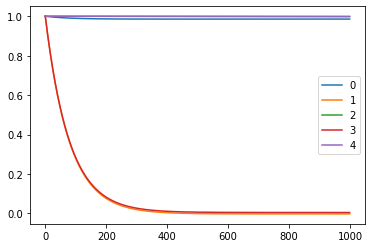

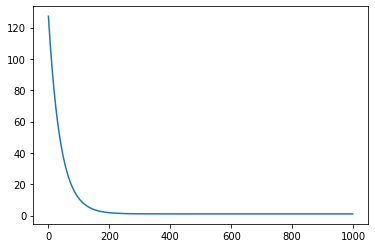

In [ ]:
# plt.plot(loss_list)
for i in range(len(ll_list[0])):
    plt.plot(np.array(ll_list)[:, i], label=i)
plt.legend()

plt.figure(2)
plt.plot(loss_list)

In [ ]:
ll.data

tensor([  -511.8735, -23543.0000,  14502.1270, -23306.9551,   7154.0786])

In [ ]:
pp.data

tensor([14993.7656])

In [ ]:
# from scipy.optimize import minimize

In [ ]:
# def min_func(x, poly):
#     return poly.subs([(p0, x[0]), (a[0], x[1]), (a[1], x[2]), (a[2], x[3]), (b[0], x[4]), (b[1], x[5]), (b[2], x[6])])

In [ ]:
# x0 = np.array([1,2,3,4,5,6,7], dtype='float')
# # min_x_NM = minimize(min_func, x0, min_poly, method='Nelder-Mead', tol=1e-6)
# # min_x_TNC = minimize(min_func, x0, min_poly, method='TNC', tol=1e-6)
# min_x_NM_bound = minimize(min_func, x0, min_poly, method='Nelder-Mead', bounds=[(1, 10) for i in range(7)], tol=1e-6)
# min_x_TNC_bound = minimize(min_func, x0, min_poly, method='TNC', bounds=[(1, 10) for i in range(7)], tol=1e-6)

In [ ]:
# min_x_NM_bound

In [ ]:
min_x_TNC_bound

     fun: -2362.76696838211
     jac: array([ 2.62529740e+02, -2.62529717e+02,  4.54747354e-05,  0.00000000e+00,
        0.00000000e+00, -1.22501559e+02, -1.13775140e+02])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 536
     nit: 8
  status: 1
 success: True
       x: array([ 1.        , 10.        ,  3.23834289,  4.22009754,  4.92715999,
       10.        , 10.        ])

In [ ]:
# min_x_TNC

In [ ]:
# gradient descent


In [ ]:
import torch
 
# # Creating a function f(X) with a slope of -5
# X = torch.arange(-5, 5, 0.1).view(-1, 1)
# func = -5 * X
 
# # Adding Gaussian noise to the function f(X) and saving it in Y
# Y = func + 0.4 * torch.randn(X.size())

In [ ]:
x = torch.tensor([1., 2.], requires_grad=True)
y = 4*x[0]*x[1]+7*x[0]

In [ ]:
x.grad

In [ ]:
def forward(para):
    return para[0]*para[2]-para[1]*para[3]

In [ ]:
loss = forward(para)

In [ ]:
a = sym.Symbol('a')
expr = a**2+3

In [ ]:
expr.subs(a, 3)

12

In [ ]:
min_poly

0.629991111344289*a1**2 - 1.58743958794568*a1*(a0 - p0) + 1.25998222268858*a1*(a2 - b0) - 1.70185953707389*b1*(a0 - p0) - 0.629991111344289*b2*(a0 - p0) + (a0 - p0)**2 - 1.58743958794568*(a0 - p0)*(a2 - b0) + 0.629991111344289*(a2 - b0)**2

In [ ]:
min_poly

0.629991111344289*a1**2 - 1.58743958794568*a1*(a0 - p0) + 1.25998222268858*a1*(a2 - b0) - 1.70185953707389*b1*(a0 - p0) - 0.629991111344289*b2*(a0 - p0) + (a0 - p0)**2 - 1.58743958794568*(a0 - p0)*(a2 - b0) + 0.629991111344289*(a2 - b0)**2

In [ ]:
X = torch.tensor([0.0 for i in range(7)], requires_grad=True)
# Y = min_func(X, min_poly)

In [ ]:
def forward(x):
    return min_poly.subs(zip(min_poly.free_symbols, x))

In [ ]:
para = torch.tensor([0.0 for i in range(7)], requires_grad=True)
step_size = 0.1
loss_GD = []
n_iter = 20

In [ ]:
para

tensor([0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [ ]:
for i in range (n_iter):

    # calculating the loss between original and predicted data points
    loss = forward(para)
    # backward pass for computing the gradients of the loss w.r.t to learnable parameters
    loss.backward()
    # updateing the parameters after each iteration
    para.data = para.data - step_size * para.grad.data
    # zeroing gradients after each iteration
    para.grad.data.zero_()
    # priting the values for understanding
    print('{}, \t{}, \t{}, \t{}'.format(i, loss.item(), para.item()))

RuntimeError: ignored

In [ ]:

# defining the function for forward pass for prediction
def forward(x):
    return w * x + b
 
# evaluating data points with Mean Square Error (MSE)
def criterion(y_pred, y):
    return torch.mean((y_pred - y) ** 2)

w = torch.tensor(-10.0, requires_grad=True)
b = torch.tensor(-20.0, requires_grad=True)
 
step_size = 0.1
loss_BGD = []
n_iter = 20

for i in range (n_iter):
    # making predictions with forward pass
    Y_pred = forward(X)
    # calculating the loss between original and predicted data points
    loss = criterion(Y_pred, Y)
    # storing the calculated loss in a list
    loss_BGD.append(loss.item())
    # backward pass for computing the gradients of the loss w.r.t to learnable parameters
    loss.backward()
    # updateing the parameters after each iteration
    w.data = w.data - step_size * w.grad.data
    b.data = b.data - step_size * b.grad.data
    # zeroing gradients after each iteration
    w.grad.data.zero_()
    b.grad.data.zero_()
    # priting the values for understanding
    print('{}, \t{}, \t{}, \t{}'.format(i, loss.item(), w.item(), b.item()))

0, 	597.9834594726562, 	-1.8522615432739258, 	-16.05585479736328
1, 	344.2311706542969, 	-7.247360706329346, 	-12.819061279296875
2, 	203.22259521484375, 	-3.616461992263794, 	-10.283576965332031
3, 	122.49346923828125, 	-6.012916564941406, 	-8.218880653381348
4, 	75.0594253540039, 	-4.393834590911865, 	-6.59108829498291
5, 	46.58382797241211, 	-5.457484245300293, 	-5.272663116455078
6, 	29.1961612701416, 	-4.7348456382751465, 	-4.228559494018555
7, 	18.43986701965332, 	-5.206404685974121, 	-3.3860504627227783
8, 	11.720961570739746, 	-4.883449554443359, 	-2.7167587280273438
9, 	7.494123458862305, 	-5.092167854309082, 	-2.178095817565918
10, 	4.821413516998291, 	-4.947566032409668, 	-1.7492527961730957
11, 	3.1252400875091553, 	-5.039727210998535, 	-1.404732346534729
12, 	2.0460243225097656, 	-4.974810600280762, 	-1.130037546157837
13, 	1.3581095933914185, 	-5.015362739562988, 	-0.9096325635910034
14, 	0.9190599322319031, 	-4.986110687255859, 	-0.7337141036987305
15, 	0.638595044612884

In [ ]:
plynm.coeffApply()

[a0 - p0]+[a1]1+[a2 - b0]2+[-b1]12+[-b2]22

In [ ]:
free_symbol_set = min_poly.free_symbols

In [ ]:
f = lambdify(((x, y, z),), min_poly(a))

In [ ]:
zip(free_symbol_set, np.array([0 for i in range(7)]))

In [ ]:
for i, j in zip(free_symbol_set, np.array([0 for i in range(7)])):
    print(i, j)

b0 0
a0 0
b2 0
p0 0
a1 0
a2 0
b1 0


In [ ]:
f = sym.lambdify(list(free_symbol_set), min_poly)

In [ ]:
f(np.array([0 for i in range(7)]))

TypeError: ignored

In [ ]:
forward(np.array([0 for i in range(7)]))

0

In [ ]:

x = sym.symbols('x0 x1')
x0, x1 = x
y = sym.symbols('y0 y1')
y0, y1 = y
expr = x0*y0 + x1*y1
# f = lambda x: x**2
f1 = sym.lambdify([x, y], expr)

In [ ]:
f1([1,2],[3,4])

11

In [ ]:
min_poly

3.25705482345182*a1**2 - 3.60946246604772*a1*(a0 - p0) + 6.51410964690363*a1*(a2 - b0) - 4.24126729947389*b1*(a0 - p0) - 3.25705482345182*b2*(a0 - p0) + (a0 - p0)**2 - 3.60946246604772*(a0 - p0)*(a2 - b0) + 3.25705482345182*(a2 - b0)**2

In [ ]:
f1([0,0,0], [0,0,0], 4)

16.0

In [ ]:
quadratic hedging of asian option under black scholes

compute pnl compute sharpe ratio